In [115]:
import imageio      #Para leer y guardar imagenes.
import numpy as np  #Operaciones con vectores, matrices, tensores...
import matplotlib.pyplot as plt    #Para realizar graficos.
import matplotlib.image as plti

import warnings     # (Opcional) Es para evitar algunos mensajes de warning.
warnings.filterwarnings('ignore')

from matplotlib import cm #Para graficar los kernels
from scipy.signal import convolve2d #Función para hacer la convolución (https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html)
import scipy.stats as st  #Para la distribucion gaussiana.

%matplotlib inline 

Funciones

In [116]:
#Matriz de transformación para YIQ.
M_YIQ = np.array([[0.299, 0.587, 0.114],
                  [0.595716, -0.274453, -0.321263],
                  [0.211456, -0.522591, 0.311135]])

#Matriz de transformación para RGB.
M_RGB = np.array([[1, 0.9563, 0.6210],
                  [1, -0.2721, -0.6474],
                  [1, -1.1070, 1.7046]])

#Función para operaciones con matrices.
def apply_matrix(img, M):
    return np.matmul(img.reshape((-1,3)), M.T).reshape(img.shape)

#Función simplificada para convertir RGB->YIQ.
def rgb2yiq(img):
    return apply_matrix(img, M_YIQ)

#Función simplificada para convertir YIQ->RGB.
def yiq2rgb(img):
    return apply_matrix(img, M_RGB)


#Filtro Gaussiano
def gaussian(N, sigma=1): #N: tamaño del kernel, sigma: Desviacion estandar
    x = np.linspace(-sigma, sigma, N+1) #linspace crea un vector de valores entre -sigma y sigma igualmente distribuidos
    gaussian_dist = np.diff(st.norm.cdf(x)) #CDF = Cumulative distribution function NORM: distribucion normal/gaussiana.
    gaussian_filter = np.outer(gaussian_dist, gaussian_dist)
    return gaussian_filter/gaussian_filter.sum()
##---------------------------------------------------------------------------------------------------------------------
#Filtros que voy a necesitar...

def box (n):   
    return 1/(n*n)*np.ones((n,n))

def circulo3x3 ():
    circulo=np.array([[0, 1, 0], 
                      [1, 1, 1], 
                      [0, 1, 0]]) 
    circulo = circulo / circulo.sum()
    return  circulo


def circulo5x5():
    circulo=np.array([[ 0, 0, 1, 0, 0 ],
                      [ 0, 1, 1, 1, 0 ],
                      [ 1, 1, 1, 1, 1 ],
                      [ 0, 1, 1, 1, 0 ],
                      [ 0, 0, 1, 0, 0]])   
    circulo = circulo / circulo.sum()
    return  circulo

def bartlett3x3():
    bartlett= np.array ([[1,2,1],
                         [2,4,2],
                         [1,2,1]])
    bartlett = bartlett / bartlett.sum()
    return  bartlett
    

def bartlett5x5():
    bartlett=np.array([[ 1, 1, 1, 1, 1 ],
                       [ 1, 2, 2, 2, 1 ],
                       [ 1, 2, 3, 2, 1 ],
                       [ 1, 2, 2, 2, 1 ],
                       [ 1, 1, 1, 1, 1]])   
    bartlett = bartlett / bartlett.sum()
    return  bartlett
def laplaceano4vecinos():
    laplaceano4=np.array([[ 0, -1,  0],
                          [-1,  4, -1],
                          [ 0, -1,  0]])
    return laplaceano4

def laplaceano8vecinos():
    laplaceano8=np.array([[-1, -1, -1],
                          [-1,  8, -1],
                          [-1, -1, -1]])
    return laplaceano8

def PAfromPB ():
    #suponiendo pb de todos 1 y normalizandolo obtengo
    pb3=np.array([[1/9, 1/9, 1/9],
                  [1/9, 1/9, 1/9],
                  [1/9, 1/9, 1/9]])
    ide = np.zeros((3, 3))
    ide[1, 1] = 1
    m3=ide-pb3
    return m3   

def dog(size,sigma1,sigma2):
    gauss1=np.zeros((size,size))
    gauss2=np.zeros((size,size))
    m=size//2
    n=size//2
    for x in range(-m,m+1):
        for y in range(-n,n+1):
            #fino
            x1=sigma1*np.sqrt((2*np.pi))
            x2=np.exp(-(x**2+ y**2)/(2*sigma1**2))
            gauss1[x+m][y+n] = (1/x1)*x2
            #grueso
            x11=sigma2*np.sqrt((2*np.pi))
            x22=np.exp(-(x**2+ y**2)/(2*sigma2**2))
            gauss2[x+m][y+n] = (1/x11)*x22           
    return gauss2-gauss1

def high_pass(kernel):
    kernel = -kernel
    kernel[kernel.shape[0] // 2, kernel.shape[1] // 2] += 1
    return kernel

    
##---------------------------------------------------------------------------------------------------------------------
#Para dibujar el Kernel en 3D.
def plot_kernel(data, ax=None):
    rows, cols = data.shape
    y, x = np.meshgrid(np.arange(rows),np.arange(cols),indexing='ij')
    if ax == None:
        fig = plt.figure()
        ax = fig.gca(projection='3d')
    _min, _max = (np.min(data), np.max(data))
    ax.plot_surface(x, y, data.T, cmap=cm.jet, vmin=_min, vmax=_max)

#Para graficar imagen, imagen filtrada y kernel en un solo grafico.
def plot_images_and_kernel(img, img_filt, kernel, titulo):
    fig = plt.figure(figsize=(17,5))
    ax1 = fig.add_subplot(131)
    ax1.imshow(img, 'gray')
    ax1.title.set_text('Input image')
    ax2 = fig.add_subplot(132)
    ax2.imshow(img_filt, 'gray')
    ax2.title.set_text(titulo)
    ax3 = fig.add_subplot(133, projection='3d')
    plot_kernel(kernel, ax=ax3)
    ax3.title.set_text('Kernel')
    plt.show()

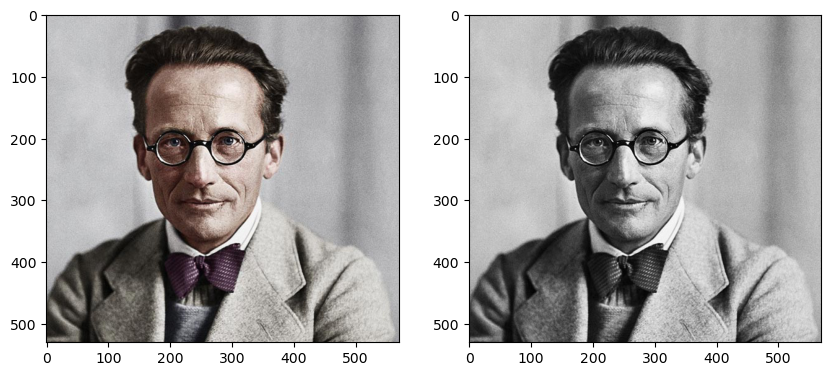

In [117]:
img_rgb = imageio.imread("img/schrodinger.jpg")/255
#Usamos una imagen en grises (tomamos el canal Y)
img = rgb2yiq(img_rgb)[:,:,0]
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img_rgb )
axes[1].imshow(img, cmap='gray')


1) Implementar los siguientes filtros simétricos (invariantes a la rotación de 90°)

1.1 - Pasabajos: Definir un kernel de tamaño NxN, con N impar. (Los pasabajos se normalizan dividiendo por la suma del kernel)

Box:

La matriz Box 3x3 es: 
[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]
 
La matriz Box 5x5 es: 
[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]
 
La matriz Box 9x9 es: 
[[0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
  0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
  0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
  0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
  0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
  0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
  0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 0.01234568 0.01234

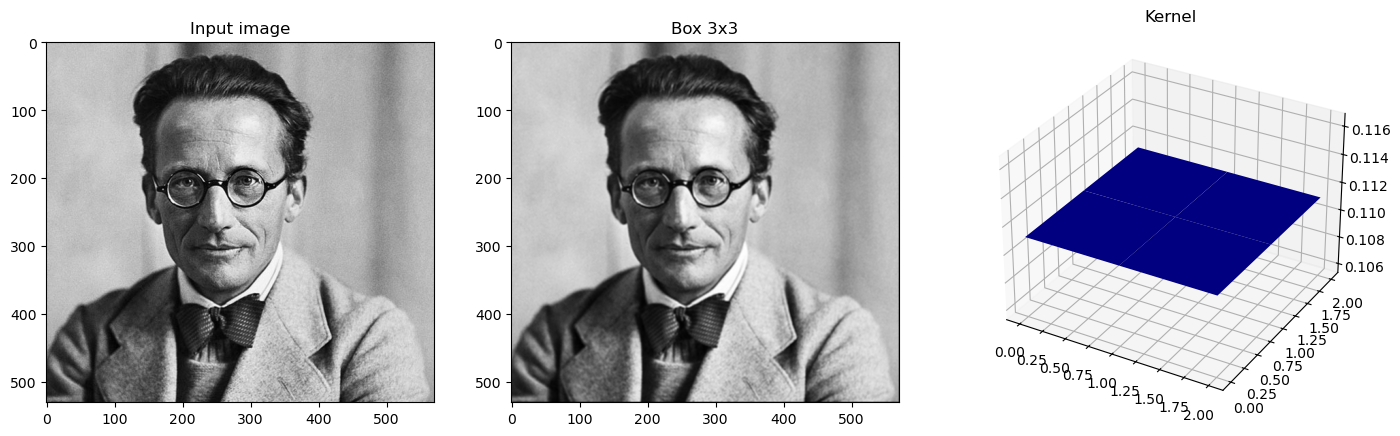

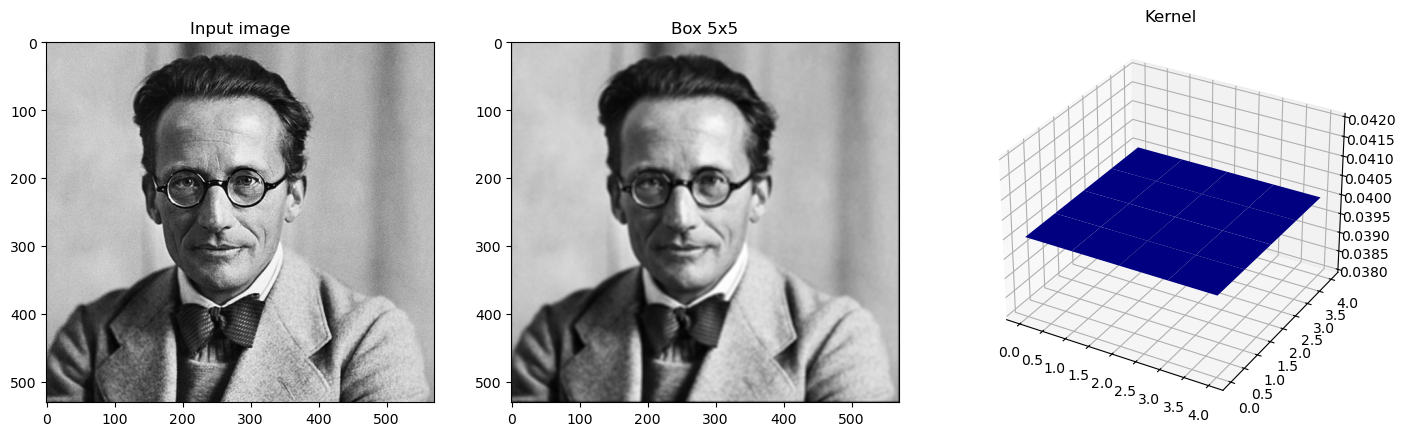

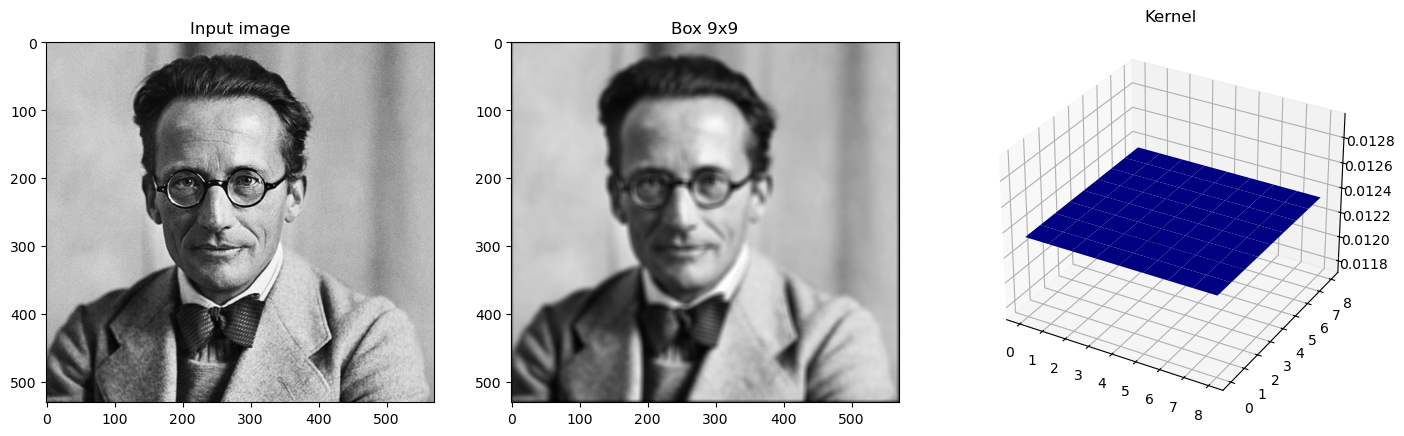

In [118]:
kernelBox3x3 = box(3)
kernelBox5x5 = box(5)
kernelBox9x9 = box(9)
# Muestro el kernel
print('La matriz Box 3x3 es: ')
print(kernelBox3x3)
print(' ')
print('La matriz Box 5x5 es: ')
print(kernelBox5x5)
print(' ')
print('La matriz Box 9x9 es: ')
print(kernelBox9x9)
# Operación de Convolución

img_filt_box3x3 = convolve2d(img,kernelBox3x3,mode='same')
img_filt_box5x5 = convolve2d(img,kernelBox5x5,mode='same')
img_filt_box9x9 = convolve2d(img,kernelBox9x9,mode='same')

# Muestro la Convolución

plot_images_and_kernel(img, img_filt_box3x3, kernelBox3x3, 'Box 3x3')
plot_images_and_kernel(img, img_filt_box5x5, kernelBox5x5, 'Box 5x5')
plot_images_and_kernel(img, img_filt_box9x9, kernelBox9x9, 'Box 9x9')

plti.imsave("image_savedbox3x3.png",img_filt_box3x3,cmap='gray')
plti.imsave("image_savedbox5x5.png",img_filt_box5x5,cmap='gray') 
plti.imsave("image_savedbox9x9.png",img_filt_box5x5,cmap='gray') 

Circle

La matriz circle 3x3 es: 
[[0.  0.2 0. ]
 [0.2 0.2 0.2]
 [0.  0.2 0. ]]
 
La matriz circle 5x5 es: 
[[0.         0.         0.07692308 0.         0.        ]
 [0.         0.07692308 0.07692308 0.07692308 0.        ]
 [0.07692308 0.07692308 0.07692308 0.07692308 0.07692308]
 [0.         0.07692308 0.07692308 0.07692308 0.        ]
 [0.         0.         0.07692308 0.         0.        ]]


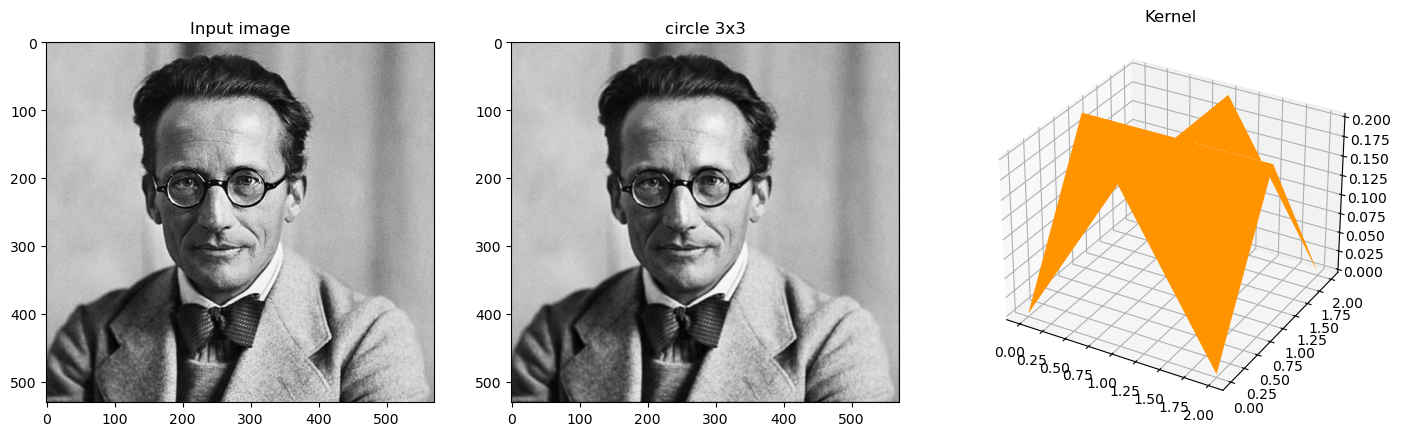

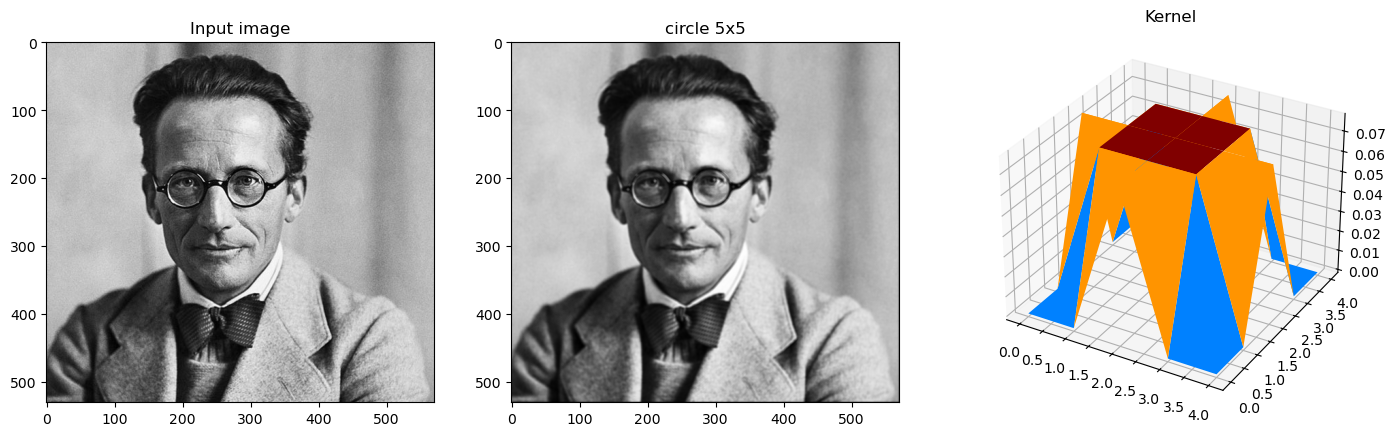

In [119]:
kernelcircle3x3 = circulo3x3()
kernelcircle5x5 = circulo5x5()

# Muestro el kernel
print('La matriz circle 3x3 es: ')
print(kernelcircle3x3)
print(' ')
print('La matriz circle 5x5 es: ')
print(kernelcircle5x5)
# Operación de Convolución

img_filt_circle3x3 = convolve2d(img,kernelcircle3x3,mode='same')
img_filt_circle5x5 = convolve2d(img,kernelcircle5x5,mode='same')

# Muestro la Convolución

plot_images_and_kernel(img, img_filt_circle3x3, kernelcircle3x3, 'circle 3x3')
plot_images_and_kernel(img, img_filt_circle5x5, kernelcircle5x5, 'circle 5x5')

plti.imsave("image_savedcircle3x3.png",img_filt_circle3x3,cmap='gray')
plti.imsave("image_savedcircle5x5.png",img_filt_circle5x5,cmap='gray') 

Bartlett (piramidal)

La matriz bartlett 3x3 es: 
[[0.0625 0.125  0.0625]
 [0.125  0.25   0.125 ]
 [0.0625 0.125  0.0625]]
 
La matriz bartlett 5x5 es: 
[[0.02857143 0.02857143 0.02857143 0.02857143 0.02857143]
 [0.02857143 0.05714286 0.05714286 0.05714286 0.02857143]
 [0.02857143 0.05714286 0.08571429 0.05714286 0.02857143]
 [0.02857143 0.05714286 0.05714286 0.05714286 0.02857143]
 [0.02857143 0.02857143 0.02857143 0.02857143 0.02857143]]


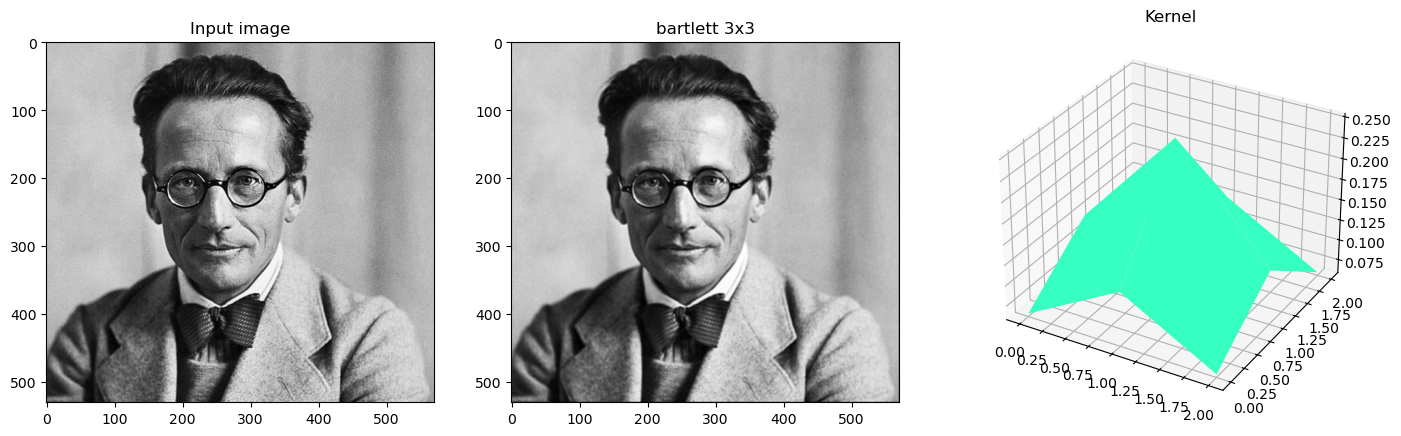

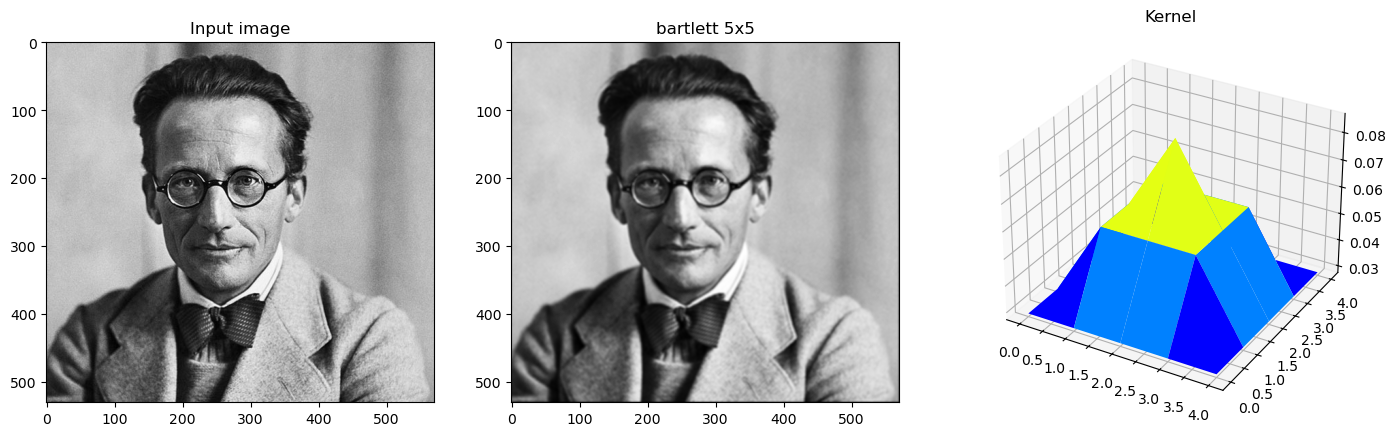

In [120]:
kernelbartlett3x3 = bartlett3x3()
kernelbartlett5x5 = bartlett5x5()

# Muestro el kernel
print('La matriz bartlett 3x3 es: ')
print(kernelbartlett3x3)
print(' ')
print('La matriz bartlett 5x5 es: ')
print(kernelbartlett5x5)
# Operación de Convolución

img_filt_bartlett3x3 = convolve2d(img,kernelbartlett3x3,mode='same')
img_filt_bartlett5x5 = convolve2d(img,kernelbartlett5x5,mode='same')

# Muestro la Convolución

plot_images_and_kernel(img, img_filt_bartlett3x3, kernelbartlett3x3, 'bartlett 3x3')
plot_images_and_kernel(img, img_filt_bartlett5x5, kernelbartlett5x5, 'bartlett 5x5')

plti.imsave("image_savedbartlett3x3.png",img_filt_bartlett3x3,cmap='gray')
plti.imsave("image_savedbartlett5x5.png",img_filt_bartlett5x5,cmap='gray')

Gaussian

La matriz gaussian 3x3 es: 
[[0.09533172 0.11809491 0.09533172]
 [0.11809491 0.14629346 0.11809491]
 [0.09533172 0.11809491 0.09533172]]
 
La matriz gaussian 5x5 es: 
[[0.02867168 0.03633314 0.0393175  0.03633314 0.02867168]
 [0.03633314 0.04604185 0.04982366 0.04604185 0.03633314]
 [0.0393175  0.04982366 0.0539161  0.04982366 0.0393175 ]
 [0.03633314 0.04604185 0.04982366 0.04604185 0.03633314]
 [0.02867168 0.03633314 0.0393175  0.03633314 0.02867168]]


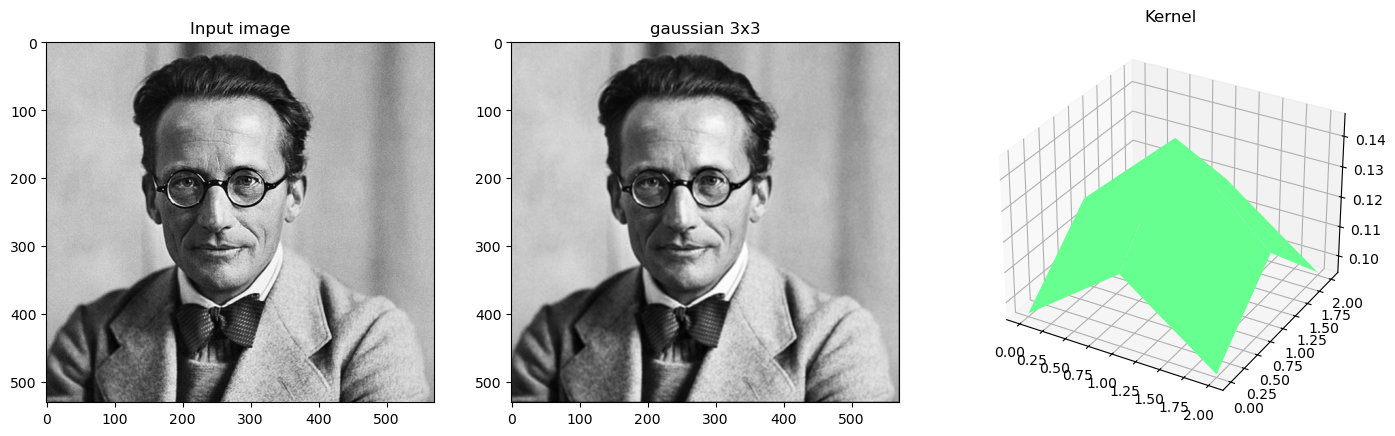

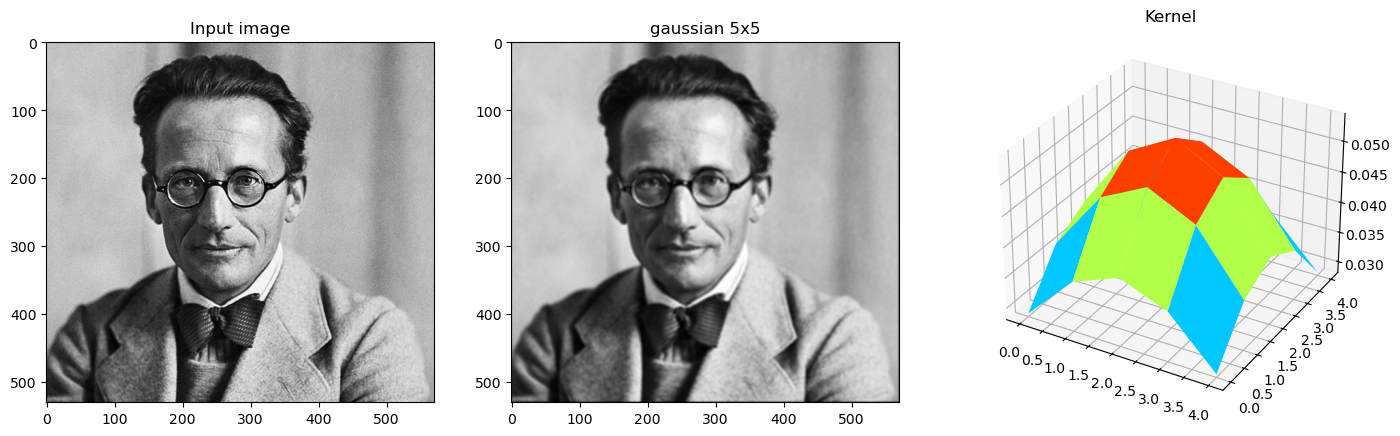

In [121]:
kernelgaussian3x3 = gaussian(3)
kernelgaussian5x5 = gaussian(5)

# Muestro el kernel
print('La matriz gaussian 3x3 es: ')
print(kernelgaussian3x3)
print(' ')
print('La matriz gaussian 5x5 es: ')
print(kernelgaussian5x5)
# Operación de Convolución

img_filt_gaussian3x3 = convolve2d(img,kernelgaussian3x3,mode='same')
img_filt_gaussian5x5 = convolve2d(img,kernelgaussian5x5,mode='same')

# Muestro la Convolución

plot_images_and_kernel(img, img_filt_gaussian3x3, kernelgaussian3x3, 'gaussian 3x3')
plot_images_and_kernel(img, img_filt_gaussian5x5, kernelgaussian5x5, 'gaussian 5x5')

plti.imsave("image_savedgaussian3x3.png",img_filt_gaussian3x3,cmap='gray')
plti.imsave("image_savedgaussian5x5.png",img_filt_gaussian5x5,cmap='gray') 

1.2 - Pasaaltos:

Laplaceano de 4 y 8 vecinos...

La matriz laplaceano 4 es: 
[[ 0 -1  0]
 [-1  4 -1]
 [ 0 -1  0]]
 
La matriz laplaceano 8 es: 
[[-1 -1 -1]
 [-1  8 -1]
 [-1 -1 -1]]


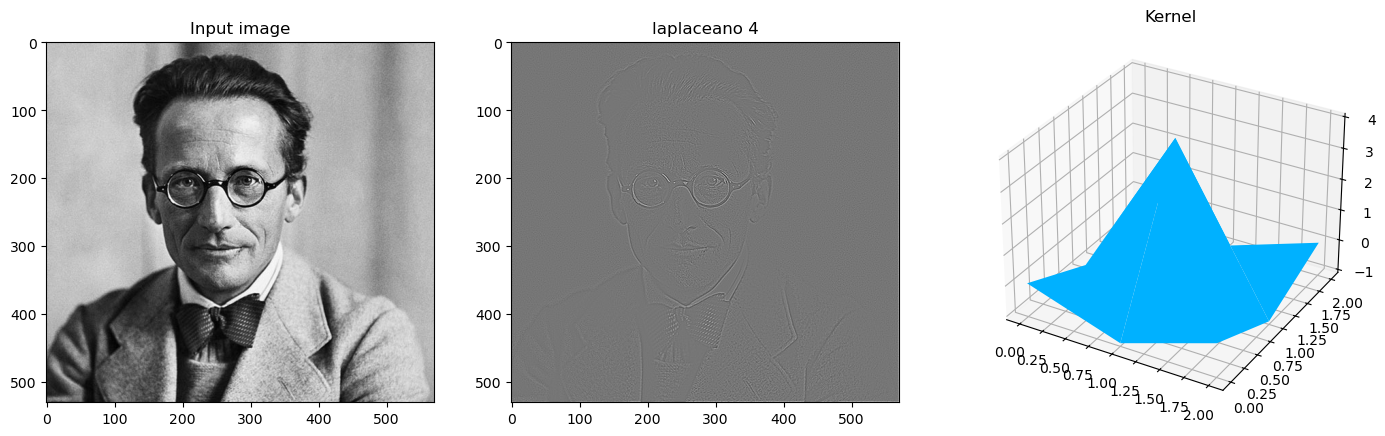

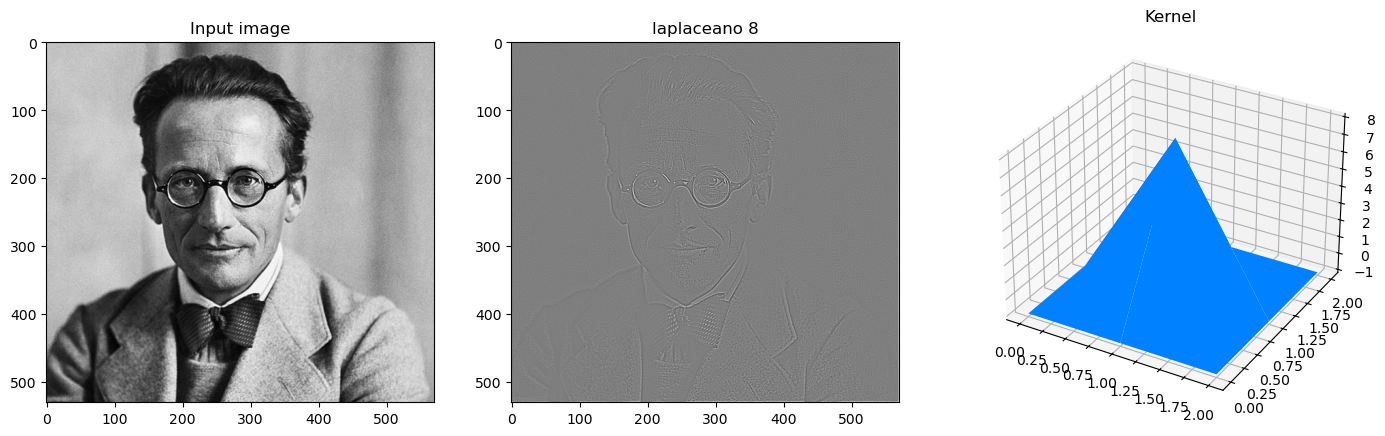

In [122]:
kernellaplaceano4 = laplaceano4vecinos()
kernellaplaceano8 = laplaceano8vecinos()

# Muestro el kernel
print('La matriz laplaceano 4 es: ')
print(kernellaplaceano4)
print(' ')
print('La matriz laplaceano 8 es: ')
print(kernellaplaceano8)
# Operación de Convolución

img_filt_laplaceano4 = convolve2d(img,kernellaplaceano4,mode='same')
img_filt_laplaceano8 = convolve2d(img,kernellaplaceano8,mode='same')

# Muestro la Convolución

plot_images_and_kernel(img, img_filt_laplaceano4, kernellaplaceano4, 'laplaceano 4')
plot_images_and_kernel(img, img_filt_laplaceano8, kernellaplaceano8, 'laplaceano 8')

plti.imsave("image_savedlaplaceano4.png",img_filt_laplaceano4,cmap='gray')
plti.imsave("image_savedlaplaceano8.png",img_filt_laplaceano8,cmap='gray')

Pasaaltos a partir de un pasabajos: PA = Id - PB

La matriz PasaAltos3  es: 
[[-0.11111111 -0.11111111 -0.11111111]
 [-0.11111111  0.88888889 -0.11111111]
 [-0.11111111 -0.11111111 -0.11111111]]


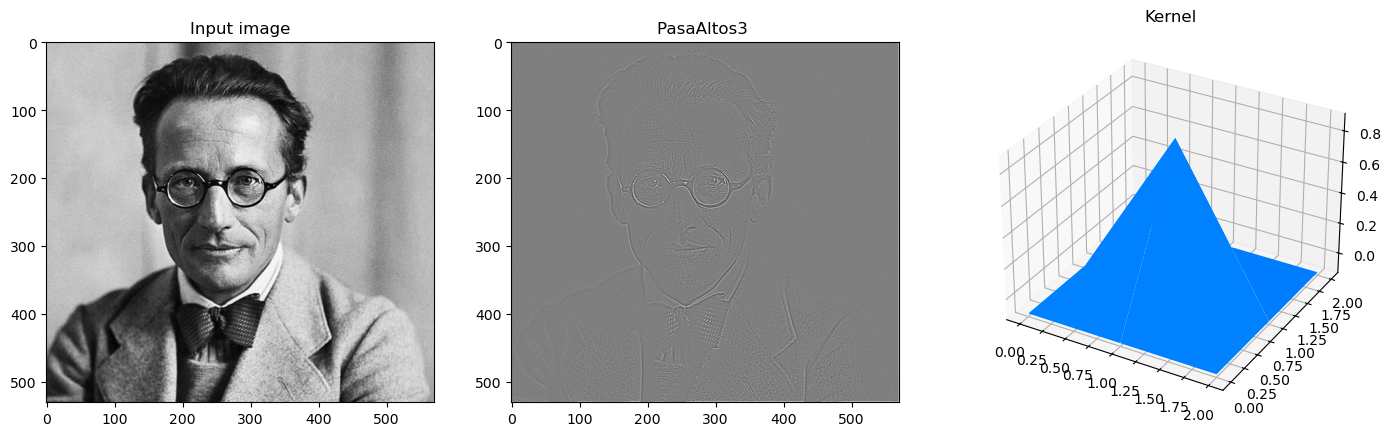

In [123]:
kernelPasaAltos3 = PAfromPB()

# Muestro el kernel
print('La matriz PasaAltos3  es: ')
print(kernelPasaAltos3)
# Operación de Convolución

img_filt_PasaAltos3 = convolve2d(img,kernelPasaAltos3,mode='same')

# Muestro la Convolución

plot_images_and_kernel(img, img_filt_PasaAltos3, kernelPasaAltos3, 'PasaAltos3 ')

plti.imsave("image_savedPasaAltos3.png",img_filt_PasaAltos3,cmap='gray')


1.3 - Pasabanda:

[[ 0.03919266  0.01941494  0.00653657  0.01941494  0.03919266]
 [ 0.01941494 -0.03454684 -0.06565728 -0.03454684  0.01941494]
 [ 0.00653657 -0.06565728 -0.10638461 -0.06565728  0.00653657]
 [ 0.01941494 -0.03454684 -0.06565728 -0.03454684  0.01941494]
 [ 0.03919266  0.01941494  0.00653657  0.01941494  0.03919266]]


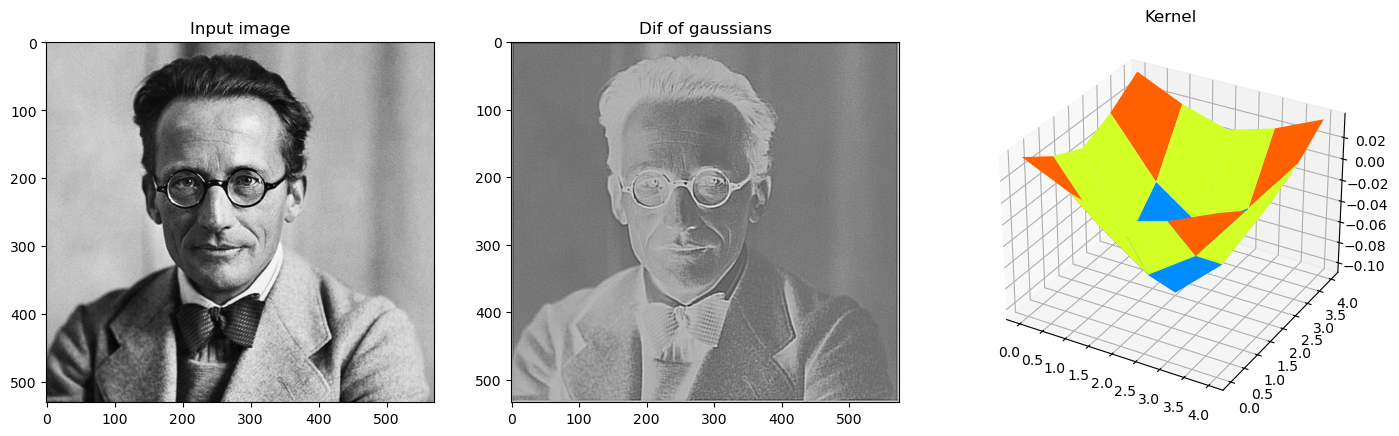

In [124]:
N = 5
G1 = 1.5
G2 = 2.5

kernel = dog(N,G1,G2)

print(kernel)

img_filt = convolve2d(img, kernel, mode='full')
plot_images_and_kernel(img, img_filt, kernel, 'Dif of gaussians')

1.4. Mejora de contraste (combinación del filtro identidad más "un poco" de pasaaltos)

[[-0.04820079 -0.0615726  -0.0615726  -0.04820079]
 [-0.0615726  -0.078654   -0.078654   -0.0615726 ]
 [-0.0615726  -0.078654    0.921346   -0.0615726 ]
 [-0.04820079 -0.0615726  -0.0615726  -0.04820079]]


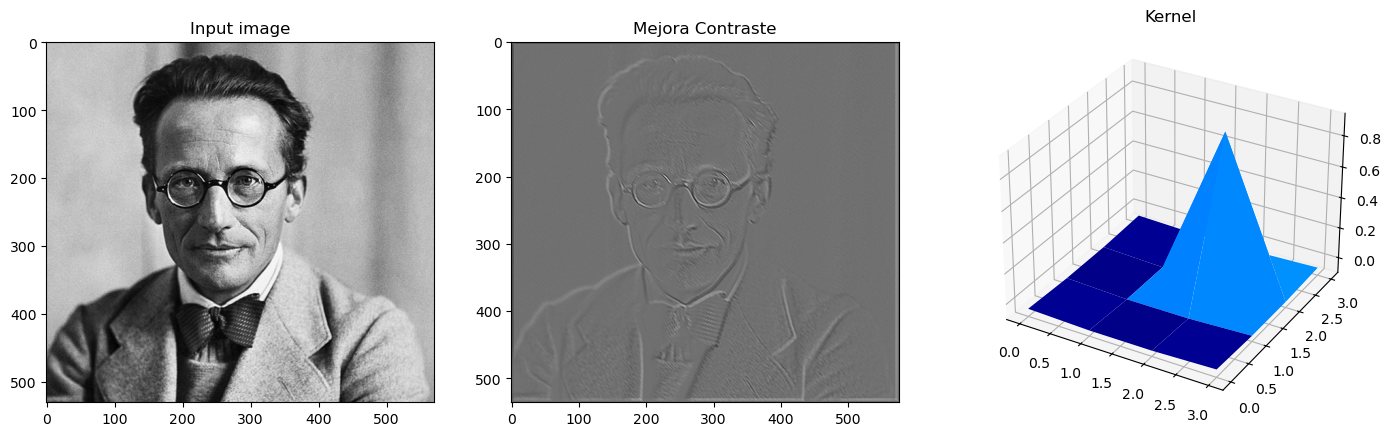

In [125]:
N = 4

kernel = high_pass(gaussian(N)) 
ker    = np.identity(N)

print(kernel)

img_filt = convolve2d(img, ker, mode='full')
img_filt = convolve2d(img_filt, kernel, mode='full')

plot_images_and_kernel(img, img_filt, kernel, 'Mejora Contraste')

2) Implementar el siguiente filtro asimétrico (direccional)
Sobel 3x3 -> Calcular valor absoluto de los gradientes Gx y Gy.

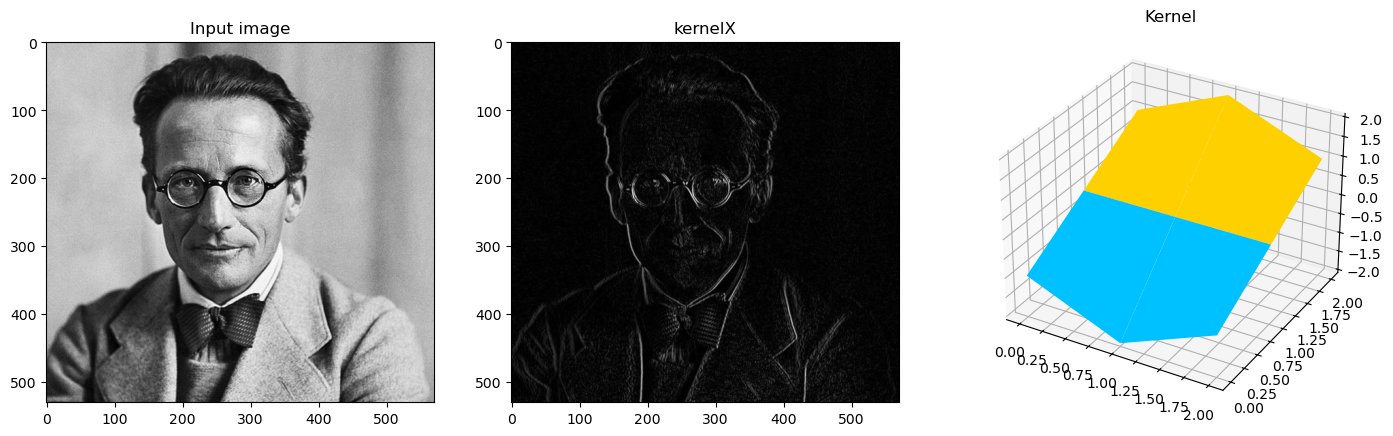

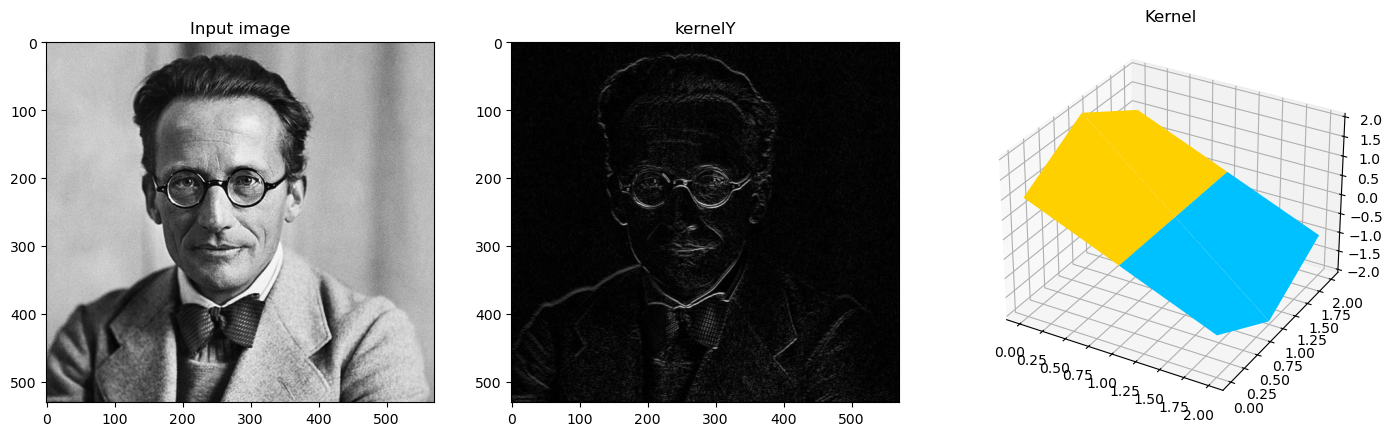

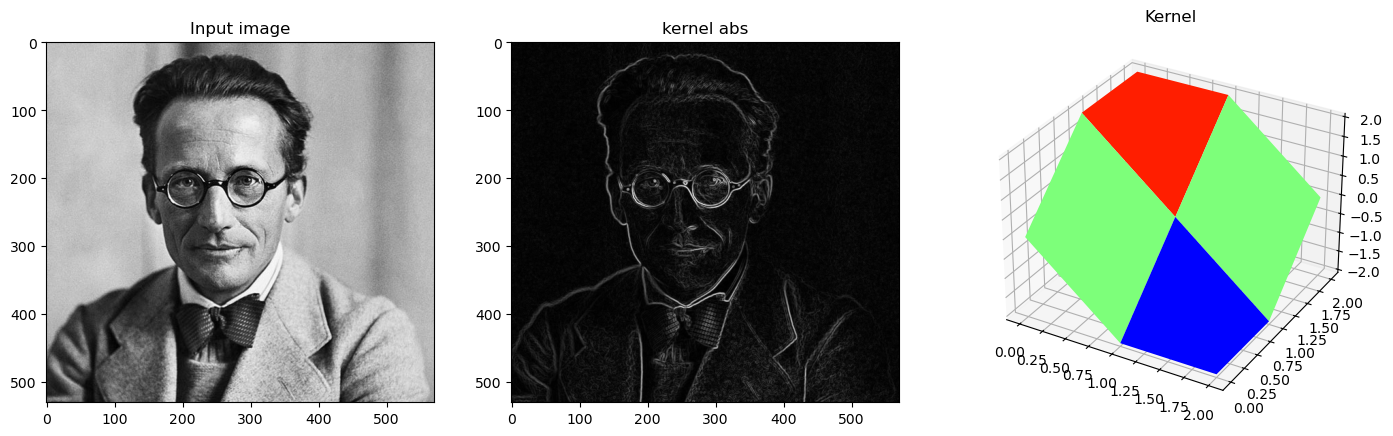

In [126]:
# Kernel Sobel Gradiente en X
kernel_X = np.array([[-1,0,1],
                     [-2,0,2],
                     [-1,0,1]])

# Kernel Sobel Gradiente en Y
kernel_Y = np.array([[1,2,1],
                    [0,0,0],
                    [-1,-2,-1]])


# Hago la convolución para cada filtro
Gx = convolve2d(img, kernel_X, mode='same',boundary='symm')
Gy = convolve2d(img, kernel_Y, mode='same',boundary='symm')

# Calculo el valor absoluto
img_filt_abs = np.sqrt(Gx*Gx + Gy*Gy)

kernel = kernel_X + kernel_Y

plot_images_and_kernel(img, abs(Gx), kernel_X, 'kernelX')
plot_images_and_kernel(img, abs(Gy), kernel_Y, 'kernelY')
plot_images_and_kernel(img, img_filt_abs, kernel, 'kernel abs')

plti.imsave("espectro.png", abs(Gx), cmap='gray')
plti.imsave("espectro2.png", abs(Gy), cmap='gray')
plti.imsave("espectro3.png", img_filt_abs, cmap='gray')

3) Aplicar un umbral al módulo del filtro de Sobel para obtener una imagen binaria con 1s y 0s.

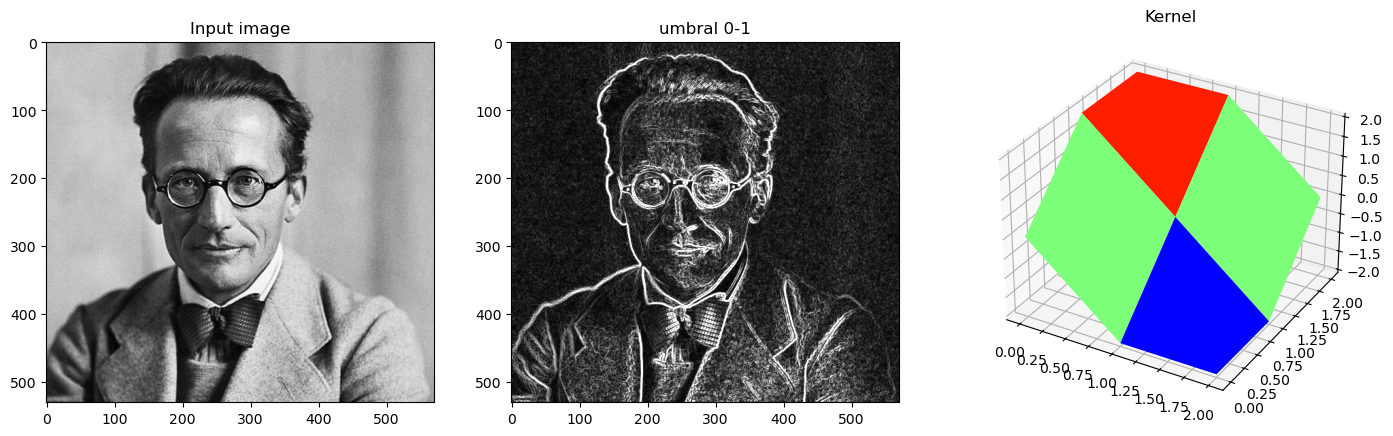

In [127]:
img_filt_abs = np.clip(img_filt_abs, 0 , 1)
          
plot_images_and_kernel(img, img_filt_abs, kernel, 'umbral 0-1')